# Projections in PorePy (first draft, large changes might happen)

In this tutorial, the focus is to illustrate the use of the projection methods that
exist in PorePy. The projection of quantities is done between a pair of subdomains that
are exactly one dimension apart, such as e.g. a rock and a fracture. The transfer is
done via the use of specific projections to and from the interface between them, where
the type of projection method used depends on the type of quantities involved (extensive
or intensive properties). 

In PorePy, the following projection methods exist:

1. Projections used for Extensive Quantities (e.g. flux):
- `primary_to_mortar_int`
- `secondary_to_mortar_int`
- `mortar_to_primary_int`
- `mortar_to_secondary_int`

2. Projections used for Intensive Quantities (e.g. pressure):
- `mortar_to_primary_avg`
- `mortar_to_secondary_avg`
- `primary_to_mortar_avg`
- `secondary_to_mortar_avg`

## Terminology and concept
Consider a fractured domain, like that shown in the left diagram below, which is
represented by a mixed-dimensional geometry. Quantities are projected between the
fracture (lower dimensional subdomain, colored in black) and the rock (higher
dimensional subdomain, colored in light grey) through an interface (right diagram,
dashed blue).

There are in total two grids neighboring an interface, and they are often referred to as
primary or secondary grids. Typically, the secondary grid is of the same dimension as
the interface, while the primary grid is of one dimension higher.

<img src='img/issue1235_frac_intf.png'  width=900>

Projecting an arbitrary quantity $\gamma$ from the higher dimensional subdomain (primary
grid, $\Omega_h$) to the lower dimensional subdomain (secondary grid, $\Omega_l$) is
done via the interface, $\Gamma$. The projection is therefore required to happen in
two-steps: first from the primary grid to the interface, and then from the interface to
the secondary grid. 

Mathematically, the process is described as follows: $$ \Omega_h\overset{\Pi_{j}^h
\gamma}{\longrightarrow} \Gamma_j\overset{{\Xi}_{l}^j (\beta)}{\longrightarrow}
\Omega_l, $$ where $$\beta = \Pi_{h}^j(\gamma).$$ Here $\Pi_{j}^h$ is the projection map
from $\Omega_h$ to $\Gamma_j,$ and $\Xi_{l}^j$ is the projection map from $\Gamma_j$ to
$\Omega_l$.

# Demonstration of projections
We will use a simulation example to demonstrate the workings of the projections of both
intensive and extensive quantities for a non-matching grid.

## Creation of non-matching mixed-dimensional geometry
First we define the model and the geometry. The model is based on the single
phase flow model found within PorePy

In [10]:
import porepy as pp
import numpy as np


class GeometryAndBC:
    """Mixins for defining the model geometry and boundary conditions."""

    def set_domain(self) -> None:
        """Defining a two-dimensional rectangular domain."""
        size = self.units.convert_units(1.0, "m")
        box: dict[str, pp.number] = {"xmax": size, "ymax": 2.0 * size}
        self._domain = pp.Domain(box)

    def set_fractures(self) -> None:
        """Setting a vertical fracture"""
        frac_1_points = self.units.convert_units(
            np.array([[0.5, 0.5], [0.5, 1.5]]), "m"
        )
        frac_1 = pp.LineFracture(frac_1_points)
        self._fractures = [frac_1]

    def bc_type_darcy_flux(self, sd: pp.Grid) -> pp.BoundaryCondition:
        """Assign dirichlet to the west and east boundaries. The rest are Neumann by default."""
        bounds = self.domain_boundary_sides(sd)
        bc = pp.BoundaryCondition(sd, bounds.west + bounds.east, "dir")
        return bc

    def bc_values_pressure(self, boundary_grid: pp.BoundaryGrid) -> np.ndarray:
        """Assign pressure boundary values for projection tutorial.
        
        We assign some non-trivial pressure boundary condition values for demonstrating
        the projection of quantities between the rock matrix, mortar grids and fracture.
        
        """
        bounds = self.domain_boundary_sides(boundary_grid)
        values = np.zeros(boundary_grid.num_cells)

        y = boundary_grid.cell_centers[1, :][bounds.west]
        values[bounds.west] = self.units.convert_units(2 * y, "Pa")
        values[bounds.east] = self.units.convert_units(2, "Pa")
        return values

We will modify `prepare_simulation` to make the mixed-dimensional grid non-matching.
This is simply done by grabbing the fracture subdomain, defining a new fracture
subdomain by refining the old one, and using the method
`replace_subdomains_and_interfaces` to update the mixed-dimensional geometry. In the
case demonstrated below, the fracture grid is refined by a ratio of 2.

In [11]:
class SinglePhaseFlowNonMatchingGrid(GeometryAndBC, pp.SinglePhaseFlow):    
    def prepare_simulation(self) -> None:
        """Run at the start of simulation. Used for initialization etc."""
        self.set_materials()
        self.set_geometry()

        # Refining the fracture grid such that the mixed-dimensional grid is
        # non-matching.
        old_frac = self.mdg.subdomains(dim=1)[0]
        new_frac = pp.refinement.refine_grid_1d(g=old_frac, ratio=2)
        self.mdg.replace_subdomains_and_interfaces({old_frac: new_frac})

        self.initialize_data_saving()

        self.set_equation_system_manager()
        self.create_variables()

        self.assign_thermodynamic_properties_to_phases()
        self.initial_condition()
        self.reset_state_from_file()
        self.set_equations()

        self.set_discretization_parameters()
        self.discretize()
        self._initialize_linear_solver()
        self.set_nonlinear_discretizations()

        # Export initial condition
        self.save_data_time_step()

params = {"meshing_arguments": {"cell_size": 0.5}}
model = SinglePhaseFlowNonMatchingGrid(params)
pp.run_time_dependent_model(model, params)

We plot the mixed-dimensional grid to visualize the location of the fracture and we plot
the fracture grid to illustrate that the mixed-dimensional grid is non-matching- 

In the plot which vizualises the fracture only, fracture cells are indicated in red
circles while fracture faces are indicated by yellow diamonds.

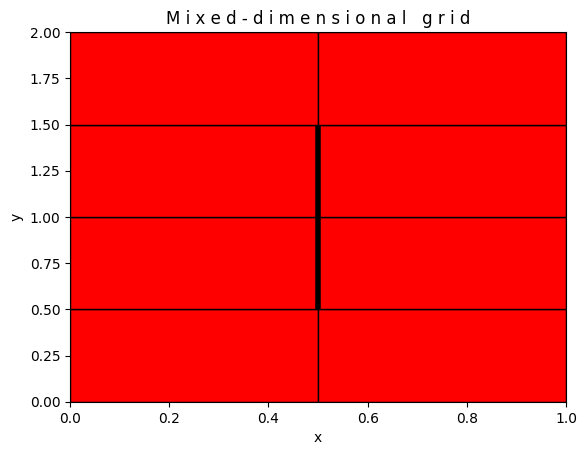

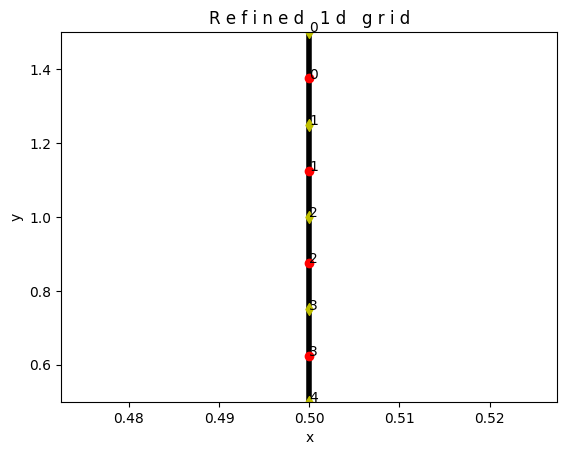

In [12]:
pp.plot_grid(model.mdg, fracturewidth_1d=4, plot_2d=True)
pp.plot_grid(
    model.mdg.subdomains(dim=1)[0], 
    fracturewidth_1d=4, 
    plot_2d=True, 
    info="cf")

We see in the 2D plot that the fracture (indicated by a bold, black, vertical line) is
neighboring two higher-dimensional grid cells on each side. However, the fracture itself
has four cells, meaning that for each face of the higher-dimensional grid which
neighbors the fracture, there are two fracture cells.

Specifically, we have the following grid-relations which we will use later:
* Fracture cells are numbered 0, 1, 2, 3.
* Fracture cells 0 and 1 are neighbors of face 7 and 23 of the matrix.
* Fracture cells 2 and 3 are neighbors of face 4 and 22 of the matrix.

Additionally we will mention that the cells of the mortar grid match the faces of the
matrix. That is, we have a mortar grid with 4 cells (two on each side of the fracture).

We now fetch the subdomains and interfaces, and then instantiate the mortar projections.
These will be used in the following sections which demonstrate the projections by
examples.

In [13]:
mdg_interfaces = model.mdg.interfaces(codim=1)
subdomains = model.interfaces_to_subdomains(mdg_interfaces)
rock = subdomains[0]
fracture = subdomains[1]

projection = pp.ad.MortarProjections(model.mdg, subdomains, mdg_interfaces, dim=1)

## Projection of intensive quantities
We will here demonstrate projections of an intensive quantity. The projections are done
by projection methods found in the MortarProjections class. The projections intended for
intensive quantities have a name ending with `_avg`. 

First we project the pressure trace from the matrix to the mortar grid, and further from
the mortar grid to the fracture:

In [14]:
from_higher = projection.primary_to_mortar_avg @ model.pressure_trace(subdomains)
to_lower = projection.mortar_to_secondary_avg @ from_higher

The resulting quantity, `to_lower`, receives projected values from both sides of the
mortar grid. The contributions from each side are summed together, resulting in the
following projected values:

In [15]:
print(to_lower.value(model.equation_system)[-4:])

[4.36150235 4.36150235 3.63849765 3.63849765]


These values are equal to the sum of the traced pressures on each side of the fracture:

In [16]:
traced_pressure_values = model.pressure_trace(subdomains).value(model.equation_system)

# Traced pressures neighboring fracture cells 0 and 1:
print(traced_pressure_values[7] + traced_pressure_values[23])

# Traced pressures neighboring fracture cells 2 and 3:
print(traced_pressure_values[4] + traced_pressure_values[22])

4.36150234741784
3.63849765258216


Projecting from the fracture to the mortar grid means (in this case) that we are
projecting _from_ two cells _to_ one cell. 

The projection works in the following way: the projection of a
quantity from (in general) several cells to _one_ cell is done by averaging the values
of the (in general) several cells. We will demonstrate this below:

In [17]:
# Pressure values in the fracture:
pressure_fracture_values = model.pressure(subdomains).value(model.equation_system)[-4:]

# Average values:
average_01 = (pressure_fracture_values[0] + pressure_fracture_values[1])/2
average_23 = (pressure_fracture_values[2] + pressure_fracture_values[3])/2

print(average_01, average_23)

# Pressure values projected from the fracture onto the mortar grid:
pressure_l = projection.secondary_to_mortar_avg @ model.pressure(subdomains)
pressure_l_value = pressure_l.value(model.equation_system)
print(pressure_l_value)


2.176056338028169 1.823943661971831
[2.17605634 1.82394366 2.17605634 1.82394366]


We see in this example that the pressure projected onto the mortar grid from e.g.
fracture cells 0 and 1 equals the average of the pressure in fracture cells 0 and 1.

### Projection of extensive quantities
Extensive quantities are projected by use of projection methods that have a name ending
with `_int`.

In the figure below we see a set of non-matching cells with areas $A_{1}$, $A_{2}$ and
$A$. Projecting from one cell to two cells means that the flux is split between the
target cells, where the amount of flux per cell is determined by the relative target
cell area (compared to that of the original cell).

<img src='img/figure_issue_1235.png'  width=900>

In the example we are about to show, values are projected to the fracture
from two sides. This means that the values in the fracture will be the sum of the values
from each mortar side. As the values are projected between non-matching grids, the
values are also distributed (in a weighted manner) to all the target fracture cells.

In [18]:
# For demonstrating how the projection works we will fetch the Darcy flux values in the
# matrix:
darcy_flux_value = model.darcy_flux(subdomains).value(model.equation_system)

# The projection of Darcy flux values to the fracture:
flux_from_h = projection.primary_to_mortar_int @ model.darcy_flux(subdomains)
flux_to_l = projection.mortar_to_secondary_int @ flux_from_h
flux_to_l_value = flux_to_l.value(model.equation_system)[-4:]

# Printing the projected flux values
print(flux_to_l_value)

# Sum of fluxes from each side of the fracture, and then divided by two as there are two
# fracture cells of equal size:
fracture_flux_01 = (darcy_flux_value[23] + darcy_flux_value[7]) / 2
fracture_flux_23 = (darcy_flux_value[22] + darcy_flux_value[4]) / 2

# Printing the "manually" computed fracture flux values
print(fracture_flux_01, fracture_flux_23)

[ 0.20618557  0.20618557 -0.20618557 -0.20618557]
0.20618556701030932 -0.20618556701030927


We see that the projected values (first print) are equal to the manually computed values
(second print).

# What we have explored
The projections used to project values between higher and lower dimensional subdomains
through an interface. Specifically this is done by considering several examples of
projections between non-matching grids.